In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'drive/MyDrive/Dataset/74k dataset mixed case insensitive.zip' -d 'Dataset'

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
from imutils.contours import sort_contours
import matplotlib.patches as patches
from PIL import Image

In [ ]:
import splitfolders
data_dir = 'Dataset/74k dataset mixed case insensitive'
splitfolders.ratio(data_dir, output="output", seed=1337, ratio=(.9, 0,0.1)) 

Copying files: 74107 files [00:08, 8581.08 files/s]


In [ ]:
train_dir="output/train"
test_dir="output/test"
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  label_mode='categorical',
  color_mode='grayscale',
  image_size=(32, 32)
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  label_mode='categorical',
  color_mode='grayscale',
  image_size=(32, 32)
  )

test_ds =  tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  label_mode='categorical',
  color_mode='grayscale',
  image_size=(32, 32)
  )

normalization_layer = tf.keras.layers.Rescaling(1./255)



norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

norm_val_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

norm_test_ds = test_ds.map(lambda x,y: (normalization_layer(x), y))


Found 66680 files belonging to 36 classes.
Using 60012 files for training.
Found 66680 files belonging to 36 classes.
Using 6668 files for validation.
Found 7427 files belonging to 36 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
def get_characters(pred_result):
    return class_names[np.argmax(pred_result)]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


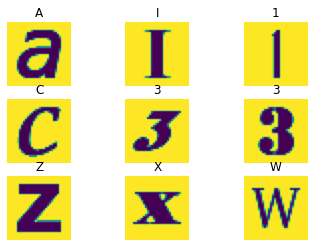

In [ ]:
for images, labels in norm_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(images[i], axis=2))
    plt.title(get_characters(labels[i]))
    plt.axis("off")

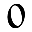

0


In [ ]:
from google.colab.patches import cv2_imshow

for images, labels in norm_train_ds.take(1):
  cv2_imshow(np.squeeze(images[i]*255, axis=2))
  print(get_characters(labels[i]))


In [ ]:
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2


def conv_block(data, filter, stride, chanDim, identity_block=False):
	# the shortcut branch of the ResNet module should be initialize as the input (identity) data
	shortcut = data
	reg=0.0005
	bnEps=2e-5
	bnMom=0.9

	# Block 1
	bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
	act1 = Activation("relu")(bn1)
	conv1 = Conv2D(int(filter * 0.25), (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act1)

	# Block 2
	bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(conv1)
	act2 = Activation("relu")(bn2)
	conv2 = Conv2D(int(filter * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg))(act2)

	# Block 3
	bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(conv2)
	act3 = Activation("relu")(bn3)
	conv3 = Conv2D(filter, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)

	# identity_block = false for using convolutional block, true for making identity block
	if not identity_block:
		shortcut = Conv2D(filter, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg))(act1)

	# add shortcut
	x = add([conv3, shortcut])

	return x

def build_resnet_model(inputShape, classes):
	chanDim = -1
	eps=2e-5
	mom=0.9
	reg=0.0005
	block_layers = (3, 3, 3)
	filters = (64, 64, 128, 256)

	# setting input
	inputs = Input(shape=inputShape)
 
 	#apply Batch Normalization and conv3d
	x = BatchNormalization(axis=chanDim, epsilon=eps, momentum=mom)(inputs)
	x = Conv2D(filters[0], (3, 3), use_bias=False, padding="same", kernel_regularizer=l2(reg))(x)

	#Insert residual blocks
	# loop over the number of stages
	for i in range(len(block_layers)):
		# initialize the stride, then apply the blocks
		# stride = (1, 1) if i == 0 else (2, 2)

		if i == 0:
			for j in range(block_layers[i]-1):
				# apply a ResNet module
				x = conv_block(x, filters[i + 1], (1, 1), chanDim, identity_block=True)
		else:
			x = conv_block(x, filters[i + 1], (2, 2), chanDim)
			for j in range(block_layers[i]-1):
				# apply a ResNet module
				x = conv_block(x, filters[i + 1], (1, 1), chanDim, identity_block=True)

	# Add last BN and dense
	x = BatchNormalization(axis=chanDim, epsilon=eps,
		momentum=mom)(x)
	x = Activation("relu")(x)
	x = AveragePooling2D((8, 8))(x)
	x = Flatten()(x)
	x = Dense(classes, kernel_regularizer=l2(reg))(x)
	x = Activation("softmax")(x)

	model = Model(inputs, x, name="resnet")

	return model

In [ ]:
tf.keras.backend.clear_session()
model = build_resnet_model((32, 32, 1), len(class_names))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 1)   4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   576         ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 64)  256         ['conv2d[0][0]']            

In [ ]:
from tensorflow.keras.optimizers import SGD
EPOCHS = 20
INIT_LR = 1e-1
BS = 128

opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

H = model.fit(
norm_train_ds,
validation_data=norm_val_ds,
epochs=EPOCHS,
verbose=1)

Epoch 1/20
1876/1876 [==============================] - 129s 61ms/step - loss: 2.5898 - accuracy: 0.5564 - val_loss: 1.8613 - val_accuracy: 0.7457
Epoch 2/20
1876/1876 [==============================] - 113s 60ms/step - loss: 1.6835 - accuracy: 0.7951 - val_loss: 1.4502 - val_accuracy: 0.8365
Epoch 3/20
1876/1876 [==============================] - 109s 58ms/step - loss: 1.4668 - accuracy: 0.8362 - val_loss: 1.3262 - val_accuracy: 0.8601
Epoch 4/20
1876/1876 [==============================] - 108s 58ms/step - loss: 1.3663 - accuracy: 0.8555 - val_loss: 1.2532 - val_accuracy: 0.8761
Epoch 5/20
1876/1876 [==============================] - 108s 58ms/step - loss: 1.3060 - accuracy: 0.8667 - val_loss: 1.1955 - val_accuracy: 0.8923
Epoch 6/20
1876/1876 [==============================] - 143s 76ms/step - loss: 1.2604 - accuracy: 0.8766 - val_loss: 1.1663 - val_accuracy: 0.8965
Epoch 7/20
1876/1876 [==============================] - 110s 59ms/step - loss: 1.2282 - accuracy: 0.8833 - val_loss: 1

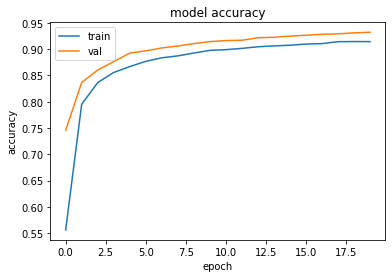

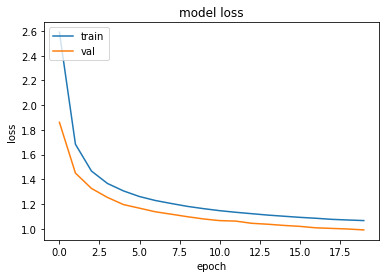

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate(norm_test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
233/233 [==============================] - 6s 23ms/step - loss: 1.1089 - accuracy: 0.9004
test loss, test acc: [1.108903169631958, 0.900363564491272]


In [ ]:
features, labels = list(zip(*norm_test_ds))

In [ ]:
testX = np.array(features[0])
testY = np.array(labels[0])
print(testX.shape)
print(testY.shape)

(32, 32, 32, 1)
(32, 36)


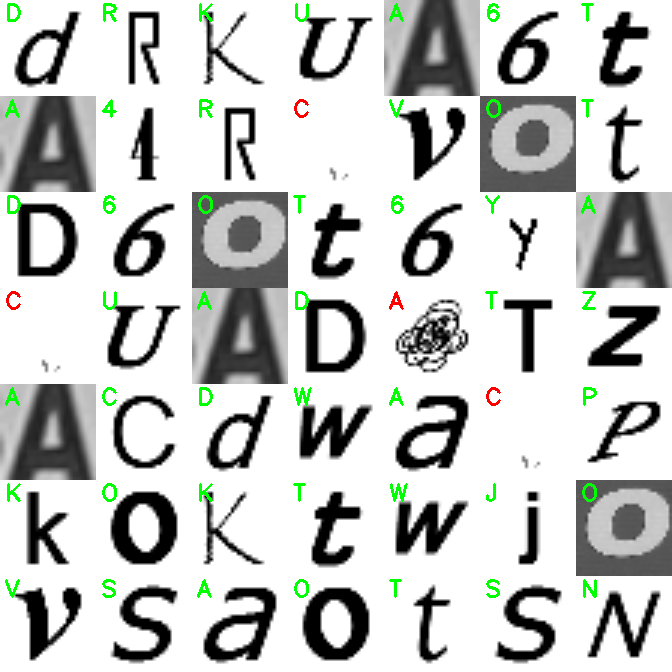

-1

In [ ]:
images = []
from imutils import build_montages
from google.colab.patches import cv2_imshow
# randomly select a few testing characters
output = []
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
  probs = model.predict(testX[np.newaxis, i])
  prediction = probs.argmax(axis=1)
  label = get_characters(probs[0])
  output+=label
  image = (testX[i] * 255).astype("uint8")
  color = (0, 255, 0)
  if prediction[0] != np.argmax(testY[i]):
    color = (0, 0, 255)
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
  color, 2)
  images.append(image)
  
montage = build_montages(images, (96, 96), (7, 7))[0]
cv2_imshow(montage)
cv2.waitKey(0)

In [ ]:
# def preprocess_image_to_predict_new_3(file_path):
#   img = cv2.imread(file_path)
#   mser = cv2.MSER_create()

#   gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting to GrayScale
#   _, bw = cv2.threshold(gray, 180,250, cv2.THRESH_BINARY)
#   cv2_imshow(bw)
#   regions, rects = mser.detectRegions(bw)
#   images = []
#   # With the rects you can e.g. crop the letters
#   for (x, y, w, h) in rects:
#     cv2.rectangle(img, (x, y), (x+w, y+h), color=(255, 0, 255), thickness=1)
#     roi = gray[y:y + h, x:x + w]
#     images.append(roi)
#     # cv2_imshow(roi)
  
#   cv2_imshow(img)

In [ ]:
def preprocess_image_to_predict(file_path):
  img = cv2.imread(file_path)
  mser = cv2.MSER_create()

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting to GrayScale
  _, bw = cv2.threshold(gray, 120,250, cv2.THRESH_BINARY)
  ret, wb = cv2.threshold(gray, 120,250, cv2.THRESH_BINARY_INV)

  ctrs1, hier = cv2.findContours(bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  ctrs2, hier = cv2.findContours(wb.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  if(len(ctrs1)>len(ctrs2)):
    ctrs = ctrs1
    img_to_crop = wb
    cv2_imshow(bw)
  else:
    ctrs = ctrs2
    img_to_crop=bw
    cv2_imshow(wb)

  sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
  images = []
  for i, ctr in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(ctr)
    # x=x-1
    # y=y-1
    # w=w+1
    # h=h+1
  
    # cv2.rectangle(img, (x-2, y-2), (x+w+2, y+h+2), color=(255, 0, 255), thickness=1)
    # roi = img_to_crop[y-2:y + h+2, x-2:x + w+2]
    cv2.rectangle(img, (x, y), (x+w, y+h), color=(255, 0, 255), thickness=1)
    roi = img_to_crop[y:y + h, x:x + w]

    (tH, tW) = roi.shape
    # if width is greater than height, resize along width dimension
    if tW > tH:
        roi = imutils.resize(roi, width=32)
    # otherwise, resize along height
    else:
        roi = imutils.resize(roi, height=32)

    # find out how much need to be padded after resize
    dX = int(max(0, 32 - tW) / 2.0)
    dY = int(max(0, 32 - tH) / 2.0)

    # pad the image to get 32 x 32
    padded = cv2.copyMakeBorder(roi, top=dY, bottom=dY,
                                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                                value=255)
    padded = cv2.resize(padded, (32, 32))

    cv2_imshow(padded)
    padded = padded.astype("float32") / 255.0
    padded = np.expand_dims(padded, axis=-1)

    images.append((padded, (x, y, w, h)))
    
  cv2_imshow(img)
  
  return images

In [ ]:
def predict(file_path):
  chars = preprocess_image_to_predict(file_path)
  
  boxes = [b[1] for b in chars]
  chars = np.array([c[0] for c in chars], dtype="float32")

  # Do predictions
  preds = model.predict(chars)
  output = ""
  for (pred, (x, y, w, h)) in zip(preds, boxes):
      i = np.argmax(pred)
      prob = pred[i]
      label = get_characters(pred)
      output += label
  print("prediction:",output)

  im = Image.open(file_path)
  fig, ax = plt.subplots()
  ax.imshow(im)
  for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2],box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

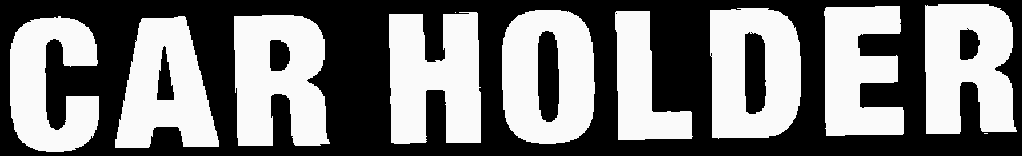

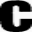

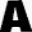

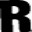

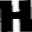

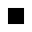

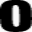

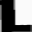

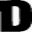

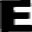

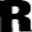

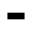

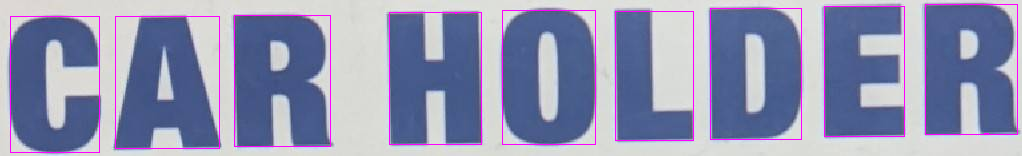

prediction: CARNLOLDERU


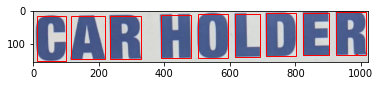

In [ ]:
predict('car_holder.jpg')

In [ ]:
model.save('OCR_Resnet_caseinsensitive_4.h5',save_format=".h5")

In [ ]:
from google.colab import files
files.download('OCR_Resnet_caseinsensitive_4.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = tf.keras.models.load_model('OCR_Resnet_caseinsensitive_4.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("OCR_Resnet_caseinsensitive_4.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpiphm3vf0/assets


1276012

In [ ]:
files.download('OCR_Resnet_caseinsensitive_4.tflite') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>